In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
import os
import requests
import json

In [ ]:
# 환경 변수 로드
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
kakao_api_key = os.getenv("KAKAO_API_KEY")
tavil_api_key = os.getenv("TAVIL_API_KEY")

In [3]:
# 상태 정의
class State(TypedDict, total=False):
    user_command: str
    intent: str
    query: str
    recipient: str
    result: str
    summary: str
    final_message: str

In [4]:
# Kakao 검색
def run_kakao_search(state: State) -> dict:
    query = state["query"]
    headers = {"Authorization": f"KakaoAK {kakao_api_key}"}
    params = {"query": query, "size": 5}
    response = requests.get("https://dapi.kakao.com/v2/local/search/keyword.json", headers=headers, params=params)
    places = response.json().get("documents", [])
    if not places:
        return {**state, "result": "검색 결과 없음"}

    structured = [
        {
            "title": p["place_name"],
            "address": p["road_address_name"],
            "url": f"https://place.map.kakao.com/{p['id']}"
        }
        for p in places
    ]
    return {**state, "result": json.dumps(structured)}

In [5]:
# Tavily 실행
def run_tavily_tool(state: State) -> dict:
    tool = TavilySearchResults()
    result = tool.invoke({"query": state["query"]})
    return {**state, "result": json.dumps(result)}

In [6]:
# 요약
def summarize_result(state: State) -> dict:
    data = state.get("result", "")
    intent = state.get("intent", "")
    try:
        if isinstance(data, str):
            data = json.loads(data)
    except:
        return {**state, "summary": "요약할 수 있는 데이터 형식이 아닙니다."}

    if intent == "장소검색":
        content = "\n".join([f"{i+1}. [{item['title']}]({item['url']}) - {item['address']}" for i, item in enumerate(data)])
        prompt = f"""다음 장소를 추천 메시지 형식으로 요약해 주세요. 링크는 반드시 포함하세요:\n{content}"""
    else:
        content = "\n".join([f"{i+1}. {item['title']} - {item['url']}" for i, item in enumerate(data)])
        prompt = f"다음 뉴스 목록을 요약해서 사용자에게 소개해 주세요:\n{content}"

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key)
    response = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "summary": response.content.strip()}

In [7]:
# 메시지 생성 노드
def compose_message(state: State) -> dict:
    summary = state.get("summary", "")
    recipient = state.get("recipient", "수신자")
    message = f"{recipient}님께 전송할 메시지입니다:\n\n{summary}"
    return {**state, "final_message": message}

In [8]:
# LLM 분석 (intent + query + recipient 추출)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=openai_api_key)

In [9]:
def analyze_command(state: State) -> dict:
    user_input = state.get("user_command", "")
    system = SystemMessage(content=(
        "사용자의 명령에서 intent(장소검색 또는 일반검색), query(검색어), recipient(메시지 수신 대상자)를 추출하세요. "
        '예: {"intent": "장소검색", "query": "성수동 브런치 카페", "recipient": "홍길동"}'
    ))
    user = HumanMessage(content=user_input)
    response = llm.invoke([system, user])
    print("📥 GPT 응답:", response.content)
    try:
        parsed = json.loads(response.content)
        return {
            "user_command": user_input,
            "intent": parsed.get("intent", ""),
            "query": parsed.get("query", ""),
            "recipient": parsed.get("recipient", "수신자")
        }
    except:
        return {
            "user_command": user_input,
            "intent": "일반검색",
            "query": user_input,
            "recipient": "수신자"
        }

In [10]:
# fallback
def fallback_node(state: State) -> dict:
    return {**state, "result": "❌ 의도 판단 실패", "summary": "", "final_message": ""}

In [11]:
# LangGraph 구성
graph_builder = StateGraph(State)
graph_builder.add_node("analyze", analyze_command)
graph_builder.add_node("tavily", run_tavily_tool)
graph_builder.add_node("kakao", run_kakao_search)
graph_builder.add_node("summarize", summarize_result)
graph_builder.add_node("compose", compose_message)
graph_builder.add_node("fallback", fallback_node)

graph_builder.add_edge(START, "analyze")
graph_builder.add_conditional_edges("analyze", lambda s: (
    "kakao" if s.get("intent") == "장소검색" else
    "tavily" if s.get("intent") == "일반검색" else
    "fallback"
), {
    "kakao": "kakao",
    "tavily": "tavily",
    "fallback": "fallback"
})
graph_builder.add_edge("kakao", "summarize")
graph_builder.add_edge("tavily", "summarize")
graph_builder.add_edge("summarize", "compose")
graph_builder.add_edge("compose", END)
graph_builder.add_edge("fallback", END)

graph = graph_builder.compile()

In [12]:

test_commands = [
    "앤트로픽 MCP 관련된 최신 뉴스를 요약해서 홍길동한테 메시지 보낼 수 있게 해줘",
    "석촌호수 근처에 수제비 추천 맛집을 홍길동에게 메시지 보낼 수 있게 해줘"
]

for test_command in test_commands:
    print("======================================")
    print("🧪 테스트 명령:", test_command)
    events = list(graph.stream({"user_command": test_command}))
    final_state = next(iter(events[-1].values()))
    print("📨 사용자 명령:", final_state.get("user_command"))
    print("👤 수신자:", final_state.get("recipient"))
    print("🧠 의도:", final_state.get("intent"))
    print("🔍 검색어:", final_state.get("query"))
    print("📩 최종 메시지:\n", final_state.get("final_message"))


🧪 테스트 명령: 앤트로픽 MCP 관련된 최신 뉴스를 요약해서 홍길동한테 메시지 보낼 수 있게 해줘
📥 GPT 응답: {"intent": "일반검색", "query": "앤트로픽 MCP 최신 뉴스", "recipient": "홍길동"}
📨 사용자 명령: 앤트로픽 MCP 관련된 최신 뉴스를 요약해서 홍길동한테 메시지 보낼 수 있게 해줘
👤 수신자: 홍길동
🧠 의도: 일반검색
🔍 검색어: 앤트로픽 MCP 최신 뉴스
📩 최종 메시지:
 홍길동님께 전송할 메시지입니다:

다음은 최근 AI 에이전트 생태계와 관련된 뉴스 목록의 요약입니다:

1. **오픈AI의 앤트로픽 MCP 채택**: 오픈AI가 앤트로픽의 MCP(Multi-Chain Protocol)를 채택함으로써 AI 에이전트 생태계에 변화가 일어나고 있다는 분석이 발표되었습니다. 이 변화는 AI 에이전트 간의 상호운용성을 강화하는 데 기여할 것으로 보입니다.

2. **경쟁사 앤트로픽의 MCP 채택**: 오픈AI가 앤트로픽의 MCP를 채택함으로써 AI 에이전트의 상호운용성이 더욱 강화될 전망입니다. 이는 AI 기술의 발전과 경쟁 구도에 중요한 영향을 미칠 것으로 예상됩니다.

3. **앤트로픽의 MCP와 리서치**: 앤트로픽의 MCP 기능이 대폭 확장되었으며, 이에 따른 리서치 기능도 업그레이드되었습니다. 이는 AI 에이전트의 효율성과 활용도를 높이는 데 기여할 것입니다.

4. **MCP 기능 확장**: 앤트로픽이 MCP 기능을 대폭 확장하고, 리서치 기능도 업그레이드하여 AI 에이전트의 성능을 향상시키고 있습니다. 이러한 변화는 AI 기술의 발전에 중요한 역할을 할 것으로 기대됩니다.

5. **MCP 열풍과 빅테크의 관심**: 앤트로픽의 AI 연결 표준인 MCP가 주목받고 있으며, 빅테크 기업들이 이 기술에 관심을 보이고 있습니다. 이는 AI 에이전트의 표준화와 상호운용성에 대한 필요성을 반영하고 있습니다.

이러한 뉴스들은 AI 에이전트의 발전과 생태계 변화에 대한 중요한 통찰을 제공합니다.
🧪 테스트 명

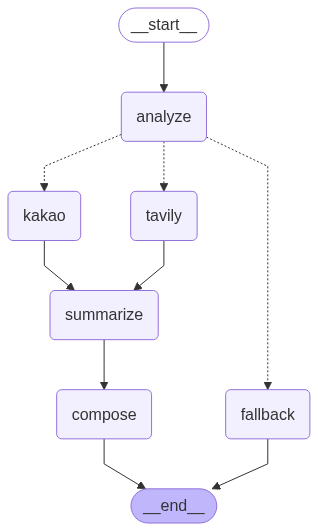

In [13]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))